In [0]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
!unzip processed-celeba-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: processed_celeba_small/celeba/New Folder With Items/052333.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052334.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052335.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052336.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052337.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052338.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052339.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052340.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052341.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052342.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052343.jpg  
  inflating: processed_celeba_small/celeba/New Folder With Items/052344.jpg  
  inflating: 

In [0]:
import torch
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

import pickle as pkl

In [0]:
data = 'processed_celeba_small/'

In [0]:
def dataloader(batch, image_size, data_dir):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    
    imageset = datasets.ImageFolder(data_dir, transform)
    image_loader = torch.utils.data.DataLoader(imageset, batch_size=batch, shuffle=True)
    
    return image_loader

In [0]:
batch = 128
image_size = 64

image_loader = dataloader(batch, image_size, data)

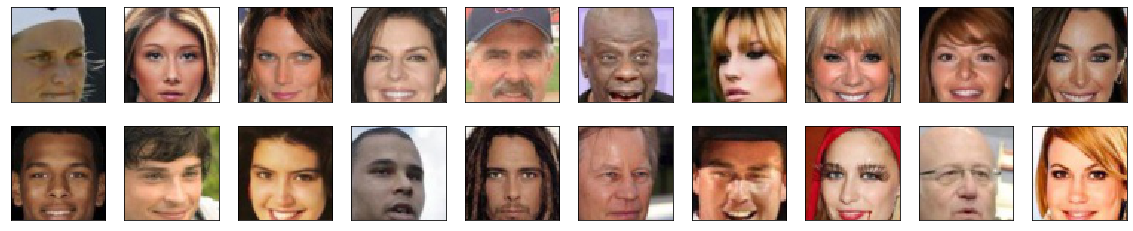

In [385]:
def imshow(image):
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0))) # must be 32, 32, 3 (w,h,d)
    
images, _ = next(iter(image_loader))

fig = plt.figure(figsize=(20, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [0]:
# output of a tanh activated generator will contain pixel values in a range from -1 to 1, 
# and so, we need to rescale our training images to a range of -1 to 1
# assumes that x is scaled from 0 - 1
# scaling normalizing your data

def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [387]:
image = images[10]
scaled_image = scale(image)

print('Min: ', scaled_image.min())
print('Max: ', scaled_image.max())

Min:  tensor(-1.)
Max:  tensor(0.8039)


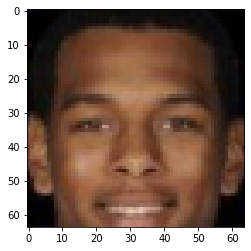

In [388]:
imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


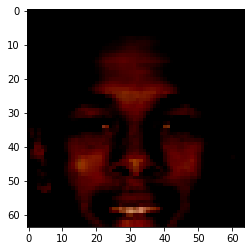

In [389]:
imshow(scaled_image)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# convolution helper function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size,
                            stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)    

In [0]:
# models
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, 1, 4, 1, 0)
        
        # self.fc = nn.Linear(conv_dim*4*4*4*4*4, 1)
        
        self.dropout = nn.Dropout(p=.5)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv3(x), .2)
        x = self.dropout(x)
        x = F.leaky_relu(self.conv4(x), .2)
        x = self.dropout(x)
        x = torch.sigmoid(self.conv5(x))
        #x = self.dropout(x)
        #print(x.shape)
        # x = x.view(-1, self.conv_dim*4*4*4*4*4)
        
        #x = self.fc(x)
        
        return x

In [0]:
# convolution helper function
def t_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                            stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)    

In [0]:
# Generator

class Generator(nn.Module):
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        #self.fc = nn.Linear(z_size, conv_dim*4*4*4*4*4)
        
        self.t_conv1 = t_conv(z_size, conv_dim*8, 4, 1, 0)
        self.t_conv2 = t_conv(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = t_conv(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = t_conv(conv_dim*2, conv_dim, 4)
        self.t_conv5 = t_conv(conv_dim, 3, 4, batch_norm=False)
        
        self.dropout = nn.Dropout(p=.5)
        
    def forward(self, x):
        #x = self.fc(x)
        
        #x = x.view(-1, self.conv_dim*4, 4, 4) # reshape to (batch_size, depth, 4, 4)
        
        x = F.relu(self.t_conv1(x))
        x = self.dropout(x)
        x = F.relu(self.t_conv2(x))
        x = self.dropout(x)
        x = F.relu(self.t_conv3(x))
        x = self.dropout(x)
        x = F.relu(self.t_conv4(x))
        x = self.dropout(x)
        x = torch.tanh(self.t_conv5(x))
        
        return x

In [0]:
# initializing weights to help model converge
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    classname = m.__class__.__name__

    if classname.find('Conv2d') != -1 and classname.find('ConvTranspose2d') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)

In [0]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [451]:
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (t_co

In [452]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [0]:
# discriminator loss, d_loss = d_real_loss + d_fake_loss
# d_loss for real images should be 1 and 0 for fake images

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*.9
    labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [0]:
def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [0]:
import torch.optim as optim

In [0]:
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
# Training involves alternating between the discriminator and generator
# d_loss = real_loss + fake_loss
# Generator will be trained on real_loss because we're trying to trick the Discriminator, hence
# should have an opposing loss function (adveserial loss)

def train(D, G, n_epochs, print_every = 50):
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
        
    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    
    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().view(-1, z_size, 1, 1)
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        
    # actual training
    g_loss_Inf = np.Inf
    
    for epoch in range(n_epochs):
        # batch training
        for batch_idx, (real_images, _) in enumerate(image_loader):
            
            batch_size = real_images.size(0) # will be needed for z vector
            real_images = scale(real_images) # necessary to fit the tanh activation function
            
            if train_on_gpu:
                real_images = real_images.cuda()
                
            # discriminator
            
            d_optimizer.zero_grad() # ensures that gradients do not accumulate
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float().view(-1, z_size, 1, 1)
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z) # create fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward() # perform backwards pass to calculate gradients
            d_optimizer.step() # actual parameter update
            
            # generator
            
            g_optimizer.zero_grad()
            
            # what happens when I don't repeat the code below
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float().view(-1, z_size, 1, 1)
            
            if train_on_gpu:
                z = z.cuda()
                
            fake_images = G(z)
            D_fake = D(fake_images)

            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            if batch_idx % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
                if g_loss < g_loss_Inf:
                    torch.save(G.state_dict(), 'G_model.pt') # saving the generator with the lowest loss
                    g_loss_Inf = g_loss
                torch.save(G.state_dict(), 'G_model_not_lowest.pt')

    
    return losses

In [435]:
losses = train(D, G, n_epochs=10)

Epoch [    1/    1] | d_loss: 1.4563 | g_loss: 0.4777
Epoch [    1/    1] | d_loss: 1.4486 | g_loss: 0.4795
Epoch [    1/    1] | d_loss: 1.4471 | g_loss: 0.4810
Epoch [    1/    1] | d_loss: 1.4443 | g_loss: 0.4816
Epoch [    1/    1] | d_loss: 1.4458 | g_loss: 0.4803
Epoch [    1/    1] | d_loss: 1.4462 | g_loss: 0.4826
Epoch [    1/    1] | d_loss: 1.4419 | g_loss: 0.4850
Epoch [    1/    1] | d_loss: 1.4446 | g_loss: 0.4855
Epoch [    1/    1] | d_loss: 1.4445 | g_loss: 0.4861
Epoch [    1/    1] | d_loss: 1.4450 | g_loss: 0.4878
Epoch [    1/    1] | d_loss: 1.4413 | g_loss: 0.4870
Epoch [    1/    1] | d_loss: 1.4378 | g_loss: 0.4899
Epoch [    1/    1] | d_loss: 1.4388 | g_loss: 0.4895
Epoch [    1/    1] | d_loss: 1.4392 | g_loss: 0.4895
Epoch [    1/    1] | d_loss: 1.4360 | g_loss: 0.4922


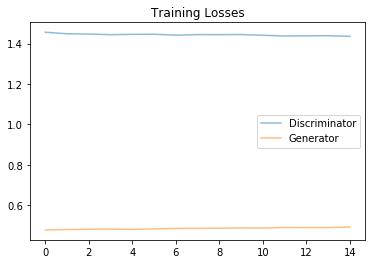

In [436]:
# plot the losses
fig, ax = plt.subplots()
losses = np.array(losses)

plt.plot(losses.T[0], label='Discriminator', alpha=0.5) # what does alpha do?
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
#G.load_state_dict(torch.load('G_model.pt', map_location='cpu'))

G.eval() # for generating samples

samples = []
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float().view(-1, z_size, 1, 1)
# move z to GPU if available
if train_on_gpu:
    fixed_z = fixed_z.cuda()

samples_z = G(fixed_z)
samples.append(samples_z)
G.train() # back to training mode
        
# Save training generator samples
with open('generated_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

In [0]:
# visualizing the generated samples
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, image in zip(axes.flatten(), samples[epoch]):
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = ((image + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        image = ax.imshow(image)#.reshape((32,32,3)))

In [0]:
with open('generated_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

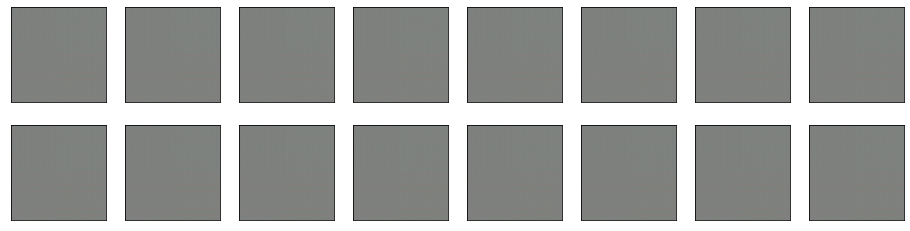

In [444]:
_ = view_samples(-1, samples) # -1 because we want images from the last epoch

### Hypotheses
- Model size; larger models have the opportunity to learn more features in a data feature space
- Optimization strategy; optimizers and number of epochs affect your final result

### Conclusion

### Recommendations
- Download the diversity face dataset from IBM